In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset, include instructions on how to download it

In [64]:
df = pd.read_csv('BCHAIN-MKPRU.csv')
df = df.iloc[::-1] # reverse order of dataframe
df['Date'] = pd.to_datetime(df['Date'])
df = df[df.Value > 0] # Entries are zero until a certain a date

# Plot bitcoin price over time with cycle peaks and bottoms

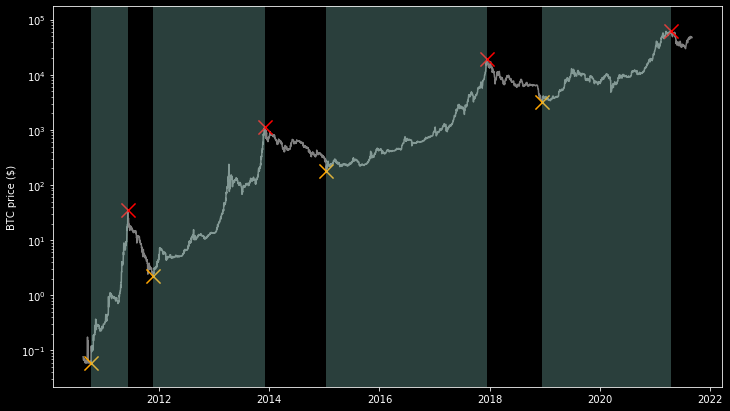

In [65]:
def get_peak(df, t0, t1):
    dfslice = df[(df.Date > t0) & (df.Date < t1)]
    return dfslice[dfslice.Value == dfslice.Value.max()] 

def get_bottom(df, t0, t1):
    dfslice = df[(df.Date > t0) & (df.Date < t1)]
    return dfslice[dfslice.Value == dfslice.Value.min()] 

def get_date(dfrow):
    return str(dfrow.Date.values.astype('datetime64[D]')[0])


# Peaks
P1 = get_peak(df, '2010-08-10', '2011-06-30')
P2 = get_peak(df, '2011-10-10', '2013-12-31')
P3 = get_peak(df, '2015-01-15', '2017-12-31')
P4 = get_peak(df, '2018-12-03', '2022-12-31')

# Troughs
B0 = get_bottom(df, '2010-10-06', str(P1.Date.values[0])[:10]) # Cheapest bitcoin in dataset
B1 = get_bottom(df, get_date(P1), get_date(P2))
B2 = get_bottom(df, get_date(P2), get_date(P3))
B3 = get_bottom(df, get_date(P3), get_date(P4))

# plt.figure(figsize=(15,7))
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,7))
ax.semilogy(df.Date, df.Value, color='grey', zorder=0)


for p in [P1,P2,P3]:
    ax.scatter(p.Date, p.Value, s=200, marker='x', c='red')
    
for b in [B0,B1,B2,B3]:
    ax.scatter(b.Date, b.Value, s=200, marker='x', c='orange')

# Plot local peak of cycle 4 (may not be global peak, have yet to find out)
#plt.scatter(P4.Date, P4.Value, s=200, marker=r"${}$".format("?"), c='red')
plt.scatter(P4.Date, P4.Value, s=200, marker="x", c='red')


datelist = [str(d)[:10] for d in df.Date]
plt.axvspan(pd.to_datetime(get_date(B0)), pd.to_datetime(get_date(P1)), alpha=0.3, label='cycle 1')
plt.axvspan(pd.to_datetime(get_date(B1)), pd.to_datetime(get_date(P2)), alpha=0.3, label='cycle 2')
plt.axvspan(pd.to_datetime(get_date(B2)), pd.to_datetime(get_date(P3)), alpha=0.3, label='cycle 3')
plt.axvspan(pd.to_datetime(get_date(B3)), pd.to_datetime(get_date(P4)), alpha=0.3, label='cycle 4')

ax.set_ylabel("BTC price ($)")
#plt.legend()
plt.show()

# Lengthening cycles and diminishing returns

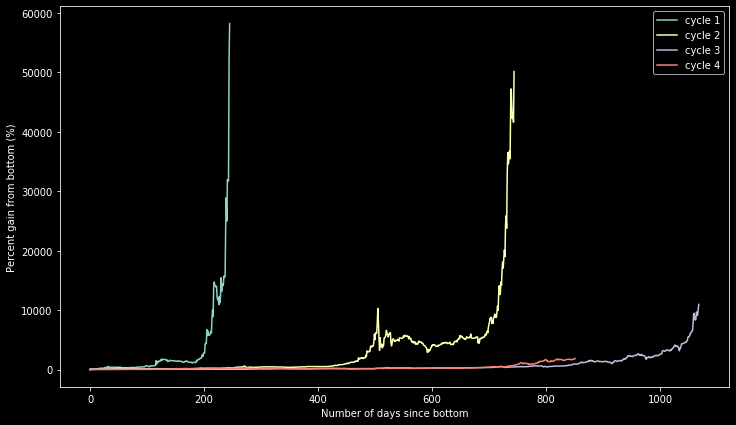

In [71]:
def get_cycle_slice(df, bottom, peak):
    return df[(df.Date >= get_date(bottom)) & (df.Date <= get_date(peak))]

def percent_from_bottom(cycle):
    return 100*((cycle.Value/cycle.iloc[0].Value)-1)

def return_on_investment(cycle):
    IVI = 10000
    mult = cycle.Value/cycle.iloc[0].Value
    FVI = invested*mult
    
    
cycle1 = get_cycle_slice(df, B0, P1).copy()
cycle2 = get_cycle_slice(df, B1, P2).copy()
cycle3 = get_cycle_slice(df, B2, P3).copy()
cycle4 = get_cycle_slice(df, B3, P4).copy()

cycle1['Percent_Gain'] = percent_from_bottom(cycle1)
cycle2['Percent_Gain'] = percent_from_bottom(cycle2)
cycle3['Percent_Gain'] = percent_from_bottom(cycle3)
cycle4['Percent_Gain'] = percent_from_bottom(cycle4)

plt.figure(figsize=(12,7))

plt.plot(cycle1.Percent_Gain.values, label='cycle 1')
plt.plot(cycle2.Percent_Gain.values, label='cycle 2')
plt.plot(cycle3.Percent_Gain.values, label='cycle 3')
plt.plot(cycle4.Percent_Gain.values, label='cycle 4')

plt.legend()
plt.xlabel('Number of days since bottom')
plt.ylabel('Percent gain from bottom (%)')
plt.show()

# Estimating returns for cycle 4?

Not much data, hard to extrapolate where cycle 4 will peak from only 3 data points

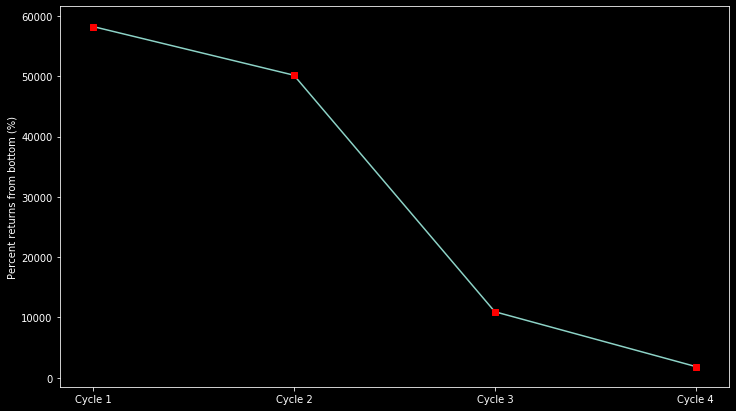

In [52]:
percent_gains_from_bottom = [
    max(cycle1.Percent_Gain.values),
    max(cycle2.Percent_Gain.values),
    max(cycle3.Percent_Gain.values),
    max(cycle4.Percent_Gain.values)
]

plt.figure(figsize=(12,7))
plt.plot(percent_gains_from_bottom, zorder=0)
plt.scatter([0,1,2,3], percent_gains_from_bottom, c='red', marker='s')
plt.xticks([0,1,2,3], ['Cycle %s'%i for i in range(1,5)])
plt.ylabel('Percent returns from bottom (%)')
plt.show()

# Risk Management

## Crude estimates of risk

Two crude estimates of risk:

1) $\text{Risk} =$ Percent change between the current and prior month's $\text{200-week ma}$.

2) $\text{Risk} =\frac{\text{50 Day MA}}{\text{50 Week MA}}$

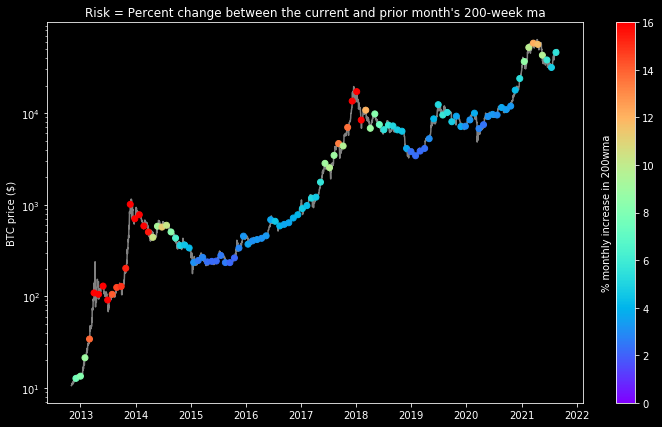

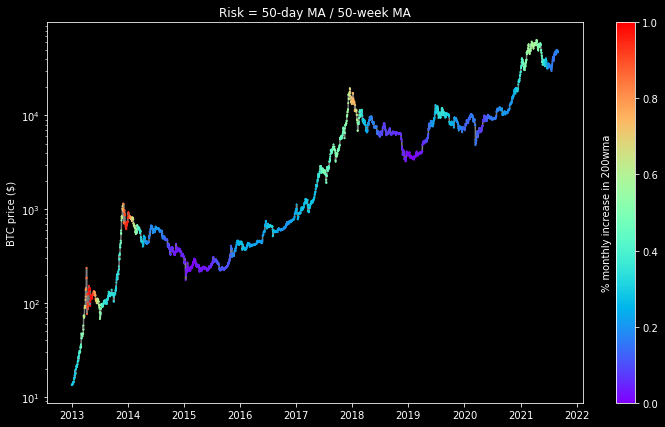

In [59]:
# ==================== Risk estimate 1 ====================

df = pd.read_csv('BCHAIN-MKPRU.csv')
df = df.iloc[::-1] # reverse order of dataframe
df['Date'] = pd.to_datetime(df['Date'])

df['200wma'] = df['Value'].rolling(window = 200*7).mean()
df = df[200*7:] # First 1400 entries won't have enough data to look back on.

plt.figure(figsize=(12,7))
plt.style.use('dark_background')

plt.semilogy(df['Date'], df['Value'], color='grey', zorder=1)
# Plot 200-week moving average
#plt.semilogy(df['Date'], df['200wma'], color='purple', zorder=2)

# Slice the dataframe into monthly prices
monthly = df[::30]
# For each month, risk is percent change between the current and a prior month.
risk = monthly['200wma'].pct_change() * 100
# Plot risk
plt.scatter(monthly['Date'], monthly['Value'], c=risk, cmap='rainbow', vmin=0, vmax=16, zorder=3)

# Axes & stuff
cbar = plt.colorbar()
cbar.set_label("% monthly increase in 200wma")
cbar.ax.yaxis.set_label_position("left")
plt.ylabel("BTC price ($)")
plt.title("Risk = Percent change between the current and prior month's 200-week ma")
plt.show()

# ==================== Risk estimate 2 ====================

df = pd.read_csv('BCHAIN-MKPRU.csv')
df = df.iloc[::-1] # reverse order of dataframe
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the 50wma and 50dma
df['50wma'] = df['Value'].rolling(window = 50*7).mean()
df['50dma'] = df['Value'].rolling(window = 50).mean()

# Drop all dates before 2010. Prices too low. 
df = df[df['Date'] > '2013-01-01']

# Define figure
plt.figure(figsize=(12,7))
plt.style.use('dark_background')

# Plot BTC price
plt.semilogy(df['Date'], df['Value'], color='grey', zorder=1)

# Slice the dataframe into monthly prices
monthly = df[::30]

# For each month, risk is percent change between the current and a prior month.
risk = df['50dma']/df['50wma']

# Normalize risk
risk = (risk-risk.min())/(risk.max()-risk.min())


# Plot risk
plt.scatter(df['Date'], df['Value'], s=1,
            c=risk, cmap='rainbow', 
            vmin=min(risk), vmax=max(risk), 
            zorder=3)

# Axes & stuff
cbar = plt.colorbar()
cbar.set_label("% monthly increase in 200wma")
cbar.ax.yaxis.set_label_position("left")
plt.ylabel("BTC price ($)")
plt.title("Risk = 50-day MA / 50-week MA")
plt.show()

# Plotting risk values too

I'm plotting this to demonstrate that the risk models above are pretty bad. Look how they decrease with time.

With this model, the optimal time to sell will appear far less risky than it should if you're waiting to make the same returns as earlier cycles. Returns will diminish at each bull cycle, so we should expect more downside risk per unit increase in price in current/future cycles. 

So we need to account for diminishing returns somewhere in the risk metric that will help us decide when to dollar cost average our buys and sells.

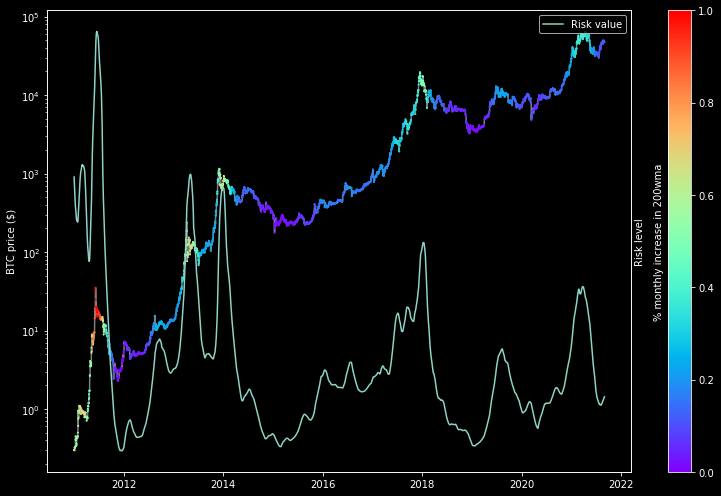

In [62]:
df = pd.read_csv('BCHAIN-MKPRU.csv')
df = df.iloc[::-1] # reverse order of dataframe
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the 50wma and 50dma
df['50wma'] = df['Value'].rolling(window = 50*7).mean()
df['50dma'] = df['Value'].rolling(window = 50).mean()

# Drop all dates before 2010. Prices too low. 
df = df[df['Date'] > '2011-01-01']

# Define figure
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(11,7))
ax2 = ax1.twinx()

# Plot BTC price
ax1.semilogy(df['Date'], df['Value'], color='grey', zorder=1)

# Slice the dataframe into monthly prices
monthly = df[::30]

# For each month, risk is percent change between the current and a prior month.
risk = df['50dma']/df['50wma']

# Normalize risk
risk = (risk-risk.min())/(risk.max()-risk.min())


# Plot risk
s = ax1.scatter(df['Date'], df['Value'], s=1,
            c=risk, cmap='rainbow', 
            vmin=min(risk), vmax=max(risk), 
            zorder=4)

ax2.plot(df['Date'], risk, zorder=1, label='Risk value')

# # Plot risk lines
# for i in


# Axes & stuff
cbar = plt.colorbar(s)
cbar.set_label("% monthly increase in 200wma")
cbar.ax.yaxis.set_label_position("left")
ax1.set_ylabel("BTC price ($)")
ax2.set_ylabel("Risk level")
ax2.set_yticks([])
plt.tight_layout()
plt.legend()
plt.show()

# Risk management 2

$Risk = f(\alpha,\beta,\gamma)^\epsilon$


Risk can be estimated as a function of:
- Current price
- Moving averages
- Volatility
- Relative strength index


Need to find a way to account for these variables in the risk score. 